In [5]:
using DrWatson
quickactivate(@__DIR__)

# Expand

Build upon the the methodology found in TimeCluster by [Ali et al](http://cs.swan.ac.uk/~csmark/publications/2019_TimeCluster.html)
but include all 300 flock agents.

A few different approaches are considered


In [2]:
using Flux, CSV, DataFrames, MLDataPattern, StatsBase, CUDA

using Plots

## Data Noramlisation and preperation

Normalise the data into the range [0, 1] as per the paper
We then create a sliding window using the defaults from the paper where stride = 1 and window_size = 60

In [6]:
df = DataFrame(CSV.File("$(datadir())/exp_raw/data.csv"; types=Float32))

function normalise(M) 
    min = minimum(minimum(eachcol(M)))
    max = maximum(maximum(eachcol(M)))
    return (M .- min) ./ (max - min)
end

normalised = Array(df) |> normalise

window_size = 60

data = slidingwindow(normalised',window_size,stride=1)

3393-element slidingwindow(adjoint(::Matrix{Float32}), 60, stride = 1) with eltype SubArray:
 [0.4964308 0.49547637 … 0.41529295 0.41362584; 0.21859932 0.21522745 … 0.08716341 0.08647672; … ; 0.52035177 0.51891536 … 0.4292123 0.42744172; 0.664805 0.6673311 … 0.80898935 0.8113594]
 [0.49547637 0.49449167 … 0.41362584 0.41195473; 0.21522745 0.21186176 … 0.08647672 0.08584033; … ; 0.51891536 0.51746523 … 0.42744172 0.4256551; 0.6673311 0.669851 … 0.8113594 0.81371814]
 [0.49449167 0.49347642 … 0.41195473 0.41028023; 0.21186176 0.2085063 … 0.08584033 0.08525832; … ; 0.51746523 0.5160018 … 0.4256551 0.42385238; 0.669851 0.6723637 … 0.81371814 0.8160656]
 [0.49347642 0.49243027 … 0.41028023 0.4085999; 0.2085063 0.20516114 … 0.08525832 0.08472662; … ; 0.5160018 0.51452553 … 0.42385238 0.4220337; 0.6723637 0.6748703 … 0.8160656 0.8184008]
 [0.49243027 0.49135324 … 0.4085999 0.40691563; 0.20516114 0.20182931 … 0.08472662 0.084243186; … ; 0.51452553 0.51303715 … 0.4220337 0.4201988; 0.6748703 0.

## Define the encoder and decoder

We can define the network shape in a couple of different ways:

- Keeping the convolution 1 dimensional and simply increasing the number of features from 3 to 900 (3 * num_of_agents) however this leads to impractical GPU memory usage if the same ratio of dimension expansion is used

- Using 2D convolution: ```window_size X num_of_agents x dimensions (3) x batch```

Lets try both approaches, adapting the 1d version to make it practical

In [ ]:
# Adjusted the dimension expansion from ≈ 21x to 10x
# Also an aditional Conv/ConvTranspose step is added to reduce the dimensionality of the encoded
# space further

function create_ae_1d()
  # Define the encoder and decoder networks 
  encoder = Chain(
  # 60x900xb
  Conv((9,), 900 => 9000, relu; pad = SamePad()),
  MaxPool((2,)),
  # 30x9000xb
  Conv((5,), 9000 => 4500, relu; pad = SamePad()),
  MaxPool((2,)),
  # 15x4500xb
  Conv((5,),4500 => 2250, relu; pad = SamePad()),
  # 15x2250xb
  MaxPool((3,)),
  Conv((3,),2250 => 1000, relu; pad = SamePad()), # included an extra conv step
  # 5x1000xb
  Flux.flatten,
  Dense(5000,5000)
  )
decoder = Chain(
  (x -> reshape(x, 5,1000,:)),
  # 5x1000xb
  ConvTranspose((3,), 1000 => 2250, relu; pad = SamePad()),
  Upsample((3,)),
  # 15x2250xb
  ConvTranspose((5,), 2250 => 4500, relu; pad = SamePad()),
  Upsample((2,)),
  # 30x4500xb
  ConvTranspose((5,), 4500 => 9000, relu; pad = SamePad()),
  Upsample((2,)),
  # 60x9000xb
  ConvTranspose((9,), 9000 => 900, relu; pad = SamePad()),
  # 60x900xb
)
return (encoder, decoder)
end

LoadError: syntax: missing comma or ) in argument list

In [ ]:
function create_ae_2d()
    # Define the encoder and decoder networks 
  encoder = Chain(
  # 60x300x3xb
    Conv((10,10), 3 => 64, relu; pad = SamePad()),
    MaxPool((2,2)),
    # 30x150x64xb
    Conv((5,5), 64 => 32, relu; pad = SamePad()),
    MaxPool((2,2)),
    # 15x75x32xb
    Conv((5,5),32 => 12, relu; pad = SamePad()),
    MaxPool((3,3)),
    # 5x25x12xb
    Flux.flatten,
    Dense(1500,1500)
    )
  decoder = Chain(
    (x -> reshape(x, 5,25,12,:)),
    # 5x25x12xb
    ConvTranspose((5,5), 12 => 32, relu; pad = SamePad()),
    Upsample((3,3)),
    # 15x75x32xb
    ConvTranspose((5,5), 32 => 64, relu; pad = SamePad()),
    Upsample((2,2)),
    # 30x150x64xb
    ConvTranspose((10,10), 64 => 3, relu; pad = SamePad()),
    Upsample((2,2))
    # 60x300x3xb
  )
  return (encoder, decoder)
 end

create_ae_2d (generic function with 1 method)

## Training
Training needs to be slightly adapted for each version of model we use

In [ ]:
function train_model_1D!(model, data, opt; epochs=20, bs=16, dev=Flux.gpu)
    model = model |> dev
    ps = params(model)
    t = shuffleobs(data)
    local l
    losses = Vector{Float64}()
    for e in 1:epochs
        for x in eachbatch(t, size=bs)
            # bs[(900, 60)]
            x  = cat(x..., dims=3)
            # bs x 900 x 60
            x  = permutedims(x, [2,1,3])
            # 60 x 900 x bs
            gs = gradient(ps) do
                l = loss(model(x),x)
            end
            Flux.update!(opt, ps, gs)
        end
        l = round(l;digits=6)
        push!(losses, l)
        println("Epoch $e/$epochs - train loss: $l")
    end
    model = model |> cpu;
    losses
 end
    

In [14]:
function train_model_2D!(model, data, opt; epochs=20, bs=16, dev=Flux.gpu)
    model = model |> dev
    ps = params(model)
    t = shuffleobs(data)
    local l
    losses = Vector{Float64}()
    for e in 1:epochs
        for x in eachbatch(t, size=bs)
            # bs[(3, 60)]
            x  = cat(x..., dims=3)
            # bs x 900 x 60
            x = reshape(x, bs, 3, 300,60)
            # bs x 3 x 300 x 60
            x  = permutedims(x, [4,3,2,1])
            # 60 x 300 x 3 x bs
            gs = gradient(ps) do
              l = loss(model(x),x)
            end
            Flux.update!(opt, ps, gs)
        end
        l = round(l;digits=6)
        push!(losses, l)
        println("Epoch $e/$epochs - train loss: $l")
    end
    model = model |> cpu;
    losses
 end
    

train_model_2D! (generic function with 1 method)

In [6]:
loss(x,y)        = Flux.Losses.mse(x, y)

loss (generic function with 1 method)

In [15]:
encoder, decoder = create_ae_2d()
model            = Chain(encoder, decoder);
losses_2D_001 = train_model_2D!(model, data, Flux.Optimise.ADAM(0.001); epochs=20);

Epoch 1/20 - train loss: 0.189127


In [ ]:
encoder, decoder = create_ae_1d()
model            = Chain(encoder, decoder);
losses_01 = train_model!(model, data, Flux.Optimise.ADAM(0.001); epochs=20);


In [ ]:
PlotlyJS.plot(
    PlotlyJS.scatter(y=losses_01, x=1:20, mode="lines+markers")
, Layout(xaxis_title="Epoch", yaxis_title="Error"))

Lets see how well it's able to reconstruct a random segment of the data

TODO: should use test data not training data

axes(t) = (Base.OneTo(300), Base.OneTo(60), Base.OneTo(3))


┌ Info: Saved animation to 
│   fn = /Users/max/Documents/JuliaProjects/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/max/Documents/JuliaProjects/Swarm/notebooks/anim_fps30.gif")
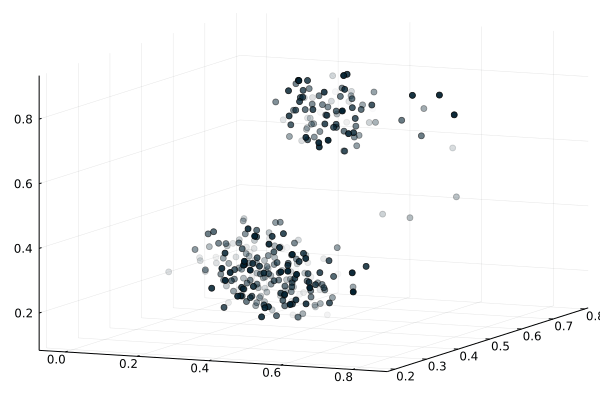

In [25]:
using Plots
gr()
# Plot the input data in blue
test = rand(data)
#test_df = DataFrame(test', :auto)

t = reshape(getobs(test),3,300,60)
t = permutedims(t, [2,3,1])
@show axes(t)
c = range(0, stop = 1, length = 60)
# plt = Plots.plot(
#     (t[1,1,1], t[1,1,2], t[1,1,3]), 
#     xlim = (0, 1),
#     ylim = (0, 1),
#     zlim = (0, 1),
#     #line_z = c,
#     color = :thermal
#     )
    
# @gif for x in 2:60
#         for y in 2:300
#             push!(plt,t[y,x,1],t[y,x,2], t[y,x,3])
#         end
#      end


     
# # Plot the reconstructed data in red
# input = Flux.unsqueeze(test', 3)
# output = model(input)
# output_df = DataFrame(reshape(output, (window_size,3)), :auto)
# @df output_df StatsPlots.plot!(cols(1),cols(2), cols(3), label="reconstructed")
using Plots

@userplot FlockPlot
@recipe function f(cp::FlockPlot)
    x, y, z = cp.args
    n = length(x)
    #linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    color --> :thermal
    aspect_ratio --> 1
    label --> false
    seriestype := :scatter
    xlim = (0, 1),
    ylim = (0, 1),
    zlim = (0, 1),
    x, y, z
end

# n = 150
# t = range(0, 2π, length = n)
# x = sin.(t)
# y = cos.(t)
# plt = Plots.plot(
#      (t[1,1,1], t[1,1,2], t[1,1,3]), 
#      xlim = (0, 1),
#      ylim = (0, 1),
#      zlim = (0, 1),
#      #line_z = c,
#      color = :thermal
#      )
    
# @gif for x in 2:60
#         for y in 2:300
#             push!(plt,t[y,x,1],t[y,x,2], t[y,x,3])
#         end
# #      end
anim = @animate for i ∈ 1:60
    flockplot(t[:,i,1],t[:,i,2],t[:,i,3])
end
gif(anim, "anim_fps30.gif", fps = 30)


